## Monte Carlo Dropout

In this notebook, we consider a simple function approximation example with noisy measurements.

In section 1, we show how we do Monte Carlo Dropout for uncertainty in the variational inference (VI) fasion using NeuralUQ.

In section 2. we do this in the conventional machine learning way.

There are significant differences in the prediction stage, but neither is wrong! 

However, we conclude that for function-wise learning & prediction, our way makes more sense. For details of Dropout method for uncertainty, please see [Dropout as a Bayesian Approximation:
Representing Model Uncertainty in Deep Learning](https://arxiv.org/pdf/1506.02142.pdf).

In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
def load_data():
    data = sio.loadmat("../dataset/func_train.mat")
    x_u_train = data["x_train"]
    u_train = data["y_train"]
    x_test = data["x_test"]
    u_test = data["y_test"]
    return x_u_train, u_train, x_test, u_test

## Section 1

In [3]:
def MCD(x_train, u_train, layers):
    surrogate = neuq.surrogates.FNN(layers=layers)
    prior = neuq.variables.fnn.Variational(layers=layers, mean=0, sigma=5.0)
    posterior = neuq.variables.fnn.MCD(layers=layers, dropout_rate=0.1, trainable=True)
    process_u = neuq.process.Process(surrogate=surrogate, prior=prior, posterior=posterior,)
    likelihood = neuq.likelihoods.Normal(
        inputs=x_train, targets=u_train, processes=[process_u], sigma=0.1,
    )
    model = neuq.models.Model(processes=[process_u], likelihoods=[likelihood])
    method = neuq.inferences.VI(
        batch_size=64,
        num_samples=1000,
        num_iterations=10000,
        optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    samples = model.run()
    return process_u, samples, model

In [4]:
x_train, u_train, x_test, u_test = load_data()
layers = [1, 50, 50, 1]
process_u, samples, model = MCD(x_train, u_train, layers)

Supporting backend tensorflow.compat.v1

Compiling a VI method

Iteration:  0 , loss:  10893.378
Iteration:  100 , loss:  7056.875
Iteration:  200 , loss:  7054.164
Iteration:  300 , loss:  7033.8193
Iteration:  400 , loss:  7026.1616
Iteration:  500 , loss:  7009.737
Iteration:  600 , loss:  6957.9478
Iteration:  700 , loss:  6933.6064
Iteration:  800 , loss:  6910.0864
Iteration:  900 , loss:  6901.4497
Iteration:  1000 , loss:  6889.947
Iteration:  1100 , loss:  6891.8247
Iteration:  1200 , loss:  6889.389
Iteration:  1300 , loss:  6877.1987
Iteration:  1400 , loss:  6883.3906
Iteration:  1500 , loss:  6873.484
Iteration:  1600 , loss:  6867.613
Iteration:  1700 , loss:  6876.659
Iteration:  1800 , loss:  6868.391
Iteration:  1900 , loss:  6874.585
Iteration:  2000 , loss:  6855.713
Iteration:  2100 , loss:  6864.229
Iteration:  2200 , loss:  6856.2676
Iteration:  2300 , loss:  6869.5273
Iteration:  2400 , loss:  6858.769
Iteration:  2500 , loss:  6856.041
Iteration:  2600 , loss:  

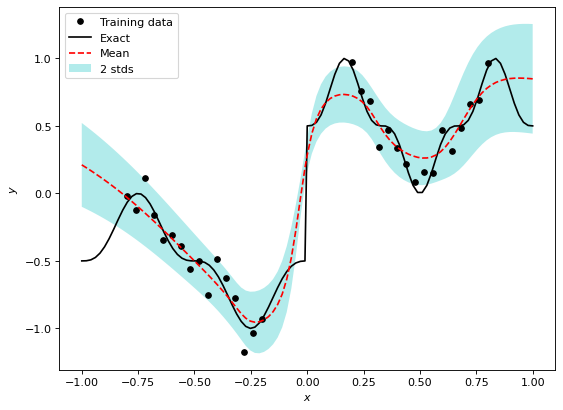

In [5]:
(u_pred,) = model.predict(x_test, samples, processes=[process_u])
neuq.utils.plot1d(x_train, u_train, x_test, u_test, u_pred[:, :, 0])

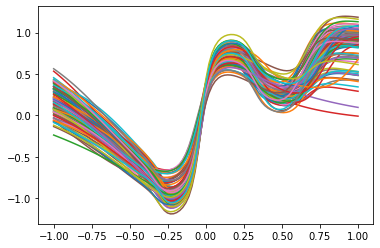

In [6]:
# plot the first 100 realizations of the posterior samples
for i in range(100):
    plt.plot(x_test[:, 0], u_pred[i, :])

#### Observations

Function-wisely, the predicted uncertainty is smooth. So is each realization of the predicted function. 

## Section 2

In [7]:
nn = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(50, activation=tf.tanh, kernel_regularizer=tf.keras.regularizers.l2(1.0)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(50, activation=tf.tanh, kernel_regularizer=tf.keras.regularizers.l2(1.0)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1),
    ]
)
nn.build(input_shape=[None, 1])

loss_op = tf.reduce_mean((nn.call(tf.constant(x_train, tf.float32), training=True) - tf.constant(u_train, tf.float32))**2) + \
        1e-5 * tf.reduce_sum(nn.losses)

opt = tf.train.AdamOptimizer(1e-3)
train_op = opt.minimize(loss_op)
sess = tf.Session()
sess.run(tf.variables_initializer(nn.trainable_variables + opt.variables()))

In [8]:
for i in range(20000):
    sess.run(train_op)
    if i % 100 == 0:
        print(i, sess.run(loss_op))

0 0.33965716
100 0.17693448
200 0.19177748
300 0.17924151
400 0.18260431
500 0.13825107
600 0.14244555
700 0.120440334
800 0.11814912
900 0.09117626
1000 0.12059354
1100 0.10944344
1200 0.10000209
1300 0.07912296
1400 0.09443055
1500 0.09033856
1600 0.0944161
1700 0.12045557
1800 0.08843523
1900 0.04577766
2000 0.083540566
2100 0.08680197
2200 0.07651549
2300 0.09530859
2400 0.05637878
2500 0.05758579
2600 0.08496323
2700 0.10059003
2800 0.09124186
2900 0.04834479
3000 0.08416366
3100 0.058442786
3200 0.05750867
3300 0.07960896
3400 0.09009304
3500 0.035663575
3600 0.08769653
3700 0.055271346
3800 0.07103979
3900 0.07205215
4000 0.06645487
4100 0.08055919
4200 0.059494928
4300 0.046574257
4400 0.085795164
4500 0.09653087
4600 0.062688366
4700 0.0511973
4800 0.061561815
4900 0.05319644
5000 0.06819959
5100 0.08130857
5200 0.039244577
5300 0.05471116
5400 0.05254053
5500 0.073464856
5600 0.048442084
5700 0.063558824
5800 0.040555514
5900 0.040400453
6000 0.034971982
6100 0.046974674
6200

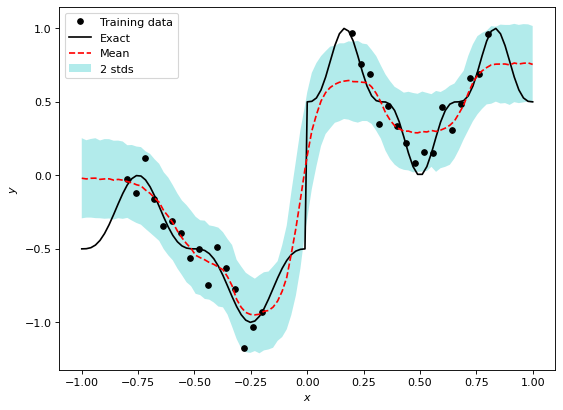

In [9]:
out = []
out_op = nn.call(tf.constant(x_test, tf.float32), training=True)
for i in range(1000):
    out += [sess.run(out_op)]
    
u_pred = np.stack(out, axis=0)
neuq.utils.plot1d(x_train, u_train, x_test, u_test, u_pred[:, :, 0])

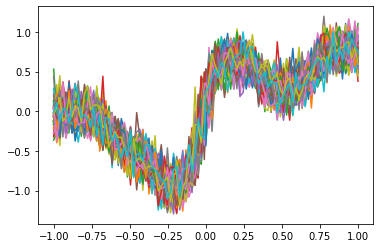

In [10]:
# plot the first 100 realizations of the posterior samples
for i in range(100):
    plt.plot(x_test[:, 0], u_pred[i, :])

#### Observations

If you look closely, the predicted uncertainty is not smooth. Each posterior function sample is very nonsmooth; almost discontinuous.

## Conclusion

1. Neither implementation is wrong!

2. The training procedure is very similar, if not the same. The differences lie in the inferences and the interpretations.

3. Non-smoothness appears in section 2's results. That is because conventionally, in the inference stage, dropout is performed for pointwise estimate, instead of function-wise one. To be specific, the uncertainty is obtained by generating many realizations of the neural network (which is done by dropping neurons), and this is done, conventionally, for each input $x$. For different inputs, those realizations of the neural network are not consistent. For example, if we estimate the outputs of two inputs, $x_1$, $x_2$, and we use 1000 posterior samples to estimate the uncertainty for each input, then, conventionally, we actually generate 2000 realizations of the neural network. This causes no trouble for pointwise estimate, e.g. in computer vision, natural language processing, when $x_1$ and $x_2$ are uncorrelated. However, in scientific machine learning, to obtain posterior samples of the function, we wish to have consistent realizations of the neural network for different inputs: the ones used to estimate uncertainty of $x_1$'s output should be the same as the ones for $x_2$. In this way, one realization of the neural network corresponds to one predicted function, and posterior samples of function are obtained.

4. In conclusion, posterior samples in section 2 are, in fact, posterior samples for the function value at each input. They are not posterior samples of the function, and hence cannot be connected when plotting each realization.